# Compute Coverage

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform coverage analysis over a region of interest.

Similar to the _Collect Observations_ example, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width.

In [15]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

The mission considers a 30-day integration period starting at noon UTC on July 14, 2022.

In [16]:
from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

Coverage analyses typically compute metrics over a spatial region. The `generate_equally_spaced_points` method in TAT-C distributes sample points over a uniform latitude-longitude grid, scaled based on a characteristic distance, set to 5000 km in this example.

In [17]:
from tatc.generation import generate_equally_spaced_points

points_df = generate_equally_spaced_points(5000e3)
display(points_df)

,point_id,geometry
0,0,POINT Z (-157.51699 -67.51699 0)
1,1,POINT Z (-112.55097 -67.51699 0)
2,2,POINT Z (-67.58495 -67.51699 0)
3,3,POINT Z (-22.61894 -67.51699 0)
4,4,POINT Z (22.34708 -67.51699 0)
5,5,POINT Z (67.3131 -67.51699 0)
6,6,POINT Z (112.27912 -67.51699 0)
7,7,POINT Z (157.24514 -67.51699 0)
8,8,POINT Z (-157.51699 -22.55097 0)
9,9,POINT Z (-112.55097 -22.55097 0)


The resulting 32 points are distributed over the globe.

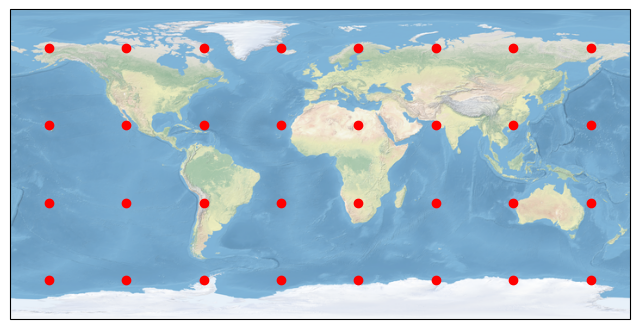

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

points_df.plot(color="red", ax=ax, transform=ccrs.PlateCarree())
ax.stock_img()
ax.set_global()

As the TAT-C analysis functions require points specified in the TAT-C format, rather than a data frame, it is often convenient to convert and store the points in a separate list.

In [19]:
from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

The `collect_observations` method can be called either using sequential or parallel computation (using `joblib`). While there is some overhead associated with parallel computation, it is usually faster on modern multi-core machines.

In [20]:
from tatc.analysis import collect_observations

import time

t = time.time()
results_list = [
    collect_observations(point, noaa20, start, end) for point in points
]
print(f"Sequential computation completed in {time.time() - t:.2f} seconds")

Sequential computation completed in 6.25 seconds


In [21]:
from tatc.analysis import collect_observations

import time
from joblib import Parallel, delayed

t = time.time()
results_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, start, end) for point in points
)
print(f"Parallel computation completed in {time.time() - t:.2f} seconds")

Parallel computation completed in 5.86 seconds


Next, we concatenate the results into a single data frame.

In [22]:
import pandas as pd

results = pd.concat(results_list, ignore_index=True)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-14 23:30:13.626441+00:00,2022-07-14 23:35:24.594257+00:00,2022-07-14 23:32:49.110349+00:00,30.035469,90.529297
1,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-15 01:09:57.306075+00:00,2022-07-15 01:17:35.995681+00:00,2022-07-15 01:13:46.650878+00:00,84.027751,71.150137
2,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-15 02:50:32.107661+00:00,2022-07-15 02:56:59.112723+00:00,2022-07-15 02:53:45.610192+00:00,41.004459,223.802226
3,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-15 04:31:23.329315+00:00,2022-07-15 04:34:35.412039+00:00,2022-07-15 04:32:59.370677+00:00,23.798760,200.191493
4,0,POINT Z (-157.51699 -67.51699 0),NOAA 20,VIIRS,2022-07-15 07:48:30.337424+00:00,2022-07-15 07:52:58.661577+00:00,2022-07-15 07:50:44.499500500+00:00,27.400167,151.767190
...,...,...,...,...,...,...,...,...,...
4459,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-12 18:28:51.557986+00:00,2022-08-12 18:34:04.353232+00:00,2022-08-12 18:31:27.955609+00:00,31.258697,324.067710
4460,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-12 21:48:45.630367+00:00,2022-08-12 21:49:49.415577+00:00,2022-08-12 21:49:17.522972+00:00,21.115155,12.621024
4461,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-12 23:25:37.442375+00:00,2022-08-12 23:31:05.304568+00:00,2022-08-12 23:28:21.373471500+00:00,32.779326,36.304442
4462,31,POINT Z (157.24514 67.38106 0),NOAA 20,VIIRS,2022-08-13 01:04:22.215027+00:00,2022-08-13 01:11:48.221137+00:00,2022-08-13 01:08:05.218082+00:00,73.798507,55.756224


The `aggregate_observations` function computes the access and revisit statistics for each point.

In [23]:
from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)
display(aggregated_results)

,geometry,point_id,satellite,instrument,start,epoch,end,access,revisit
0,POINT Z (-157.51699 -67.51699 0),0,NOAA 20,VIIRS,2022-07-14 23:30:13.626441+00:00,2022-07-14 23:32:49.110349056+00:00,2022-07-14 23:35:24.594257+00:00,0 days 00:05:10.967816,NaT
1,POINT Z (-157.51699 -67.51699 0),0,NOAA 20,VIIRS,2022-07-15 01:09:57.306075+00:00,2022-07-15 01:13:46.650877952+00:00,2022-07-15 01:17:35.995681+00:00,0 days 00:07:38.689606,0 days 01:34:32.711818
2,POINT Z (-157.51699 -67.51699 0),0,NOAA 20,VIIRS,2022-07-15 02:50:32.107661+00:00,2022-07-15 02:53:45.610191872+00:00,2022-07-15 02:56:59.112723+00:00,0 days 00:06:27.005062,0 days 01:32:56.111980
3,POINT Z (-157.51699 -67.51699 0),0,NOAA 20,VIIRS,2022-07-15 04:31:23.329315+00:00,2022-07-15 04:32:59.370676992+00:00,2022-07-15 04:34:35.412039+00:00,0 days 00:03:12.082724,0 days 01:34:24.216592
4,POINT Z (-157.51699 -67.51699 0),0,NOAA 20,VIIRS,2022-07-15 07:48:30.337424+00:00,2022-07-15 07:50:44.499500544+00:00,2022-07-15 07:52:58.661577+00:00,0 days 00:04:28.324153,0 days 03:13:54.925385
...,...,...,...,...,...,...,...,...,...
4459,POINT Z (157.24514 67.38106 0),31,NOAA 20,VIIRS,2022-08-12 18:28:51.557986+00:00,2022-08-12 18:31:27.955609088+00:00,2022-08-12 18:34:04.353232+00:00,0 days 00:05:12.795246,0 days 01:33:22.348289
4460,POINT Z (157.24514 67.38106 0),31,NOAA 20,VIIRS,2022-08-12 21:48:45.630367+00:00,2022-08-12 21:49:17.522971904+00:00,2022-08-12 21:49:49.415577+00:00,0 days 00:01:03.785210,0 days 03:14:41.277135
4461,POINT Z (157.24514 67.38106 0),31,NOAA 20,VIIRS,2022-08-12 23:25:37.442375+00:00,2022-08-12 23:28:21.373471488+00:00,2022-08-12 23:31:05.304568+00:00,0 days 00:05:27.862193,0 days 01:35:48.026798
4462,POINT Z (157.24514 67.38106 0),31,NOAA 20,VIIRS,2022-08-13 01:04:22.215027+00:00,2022-08-13 01:08:05.218082048+00:00,2022-08-13 01:11:48.221137+00:00,0 days 00:07:26.006110,0 days 01:33:16.910459


The `reduce_observations` function computes descriptive statistics for each point.

In [24]:
from tatc.analysis import reduce_observations

reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT Z (-157.51699 -67.51699 0),0 days 00:05:30.623220,0 days 03:11:45.894393,216
1,1,POINT Z (-112.55097 -67.51699 0),0 days 00:05:27.458383,0 days 03:08:40.137703,220
2,2,POINT Z (-67.58495 -67.51699 0),0 days 00:05:26.605462,0 days 03:08:13.864107,220
3,3,POINT Z (-22.61894 -67.51699 0),0 days 00:05:30.603801,0 days 03:10:24.345981,218
4,4,POINT Z (22.34708 -67.51699 0),0 days 00:05:30.457130,0 days 03:11:46.073491,216
5,5,POINT Z (67.3131 -67.51699 0),0 days 00:05:26.053693,0 days 03:11:05.197080,220
6,6,POINT Z (112.27912 -67.51699 0),0 days 00:05:28.794415,0 days 03:11:02.062489,220
7,7,POINT Z (157.24514 -67.51699 0),0 days 00:05:28.645462,0 days 03:12:51.262517,218
8,8,POINT Z (-157.51699 -22.55097 0),0 days 00:05:42.864787,0 days 10:28:27.927617,68
9,9,POINT Z (-112.55097 -22.55097 0),0 days 00:05:53.476411,0 days 10:47:46.979011,66


Finally, we can visualize results, first converting metrics to numeric formats.

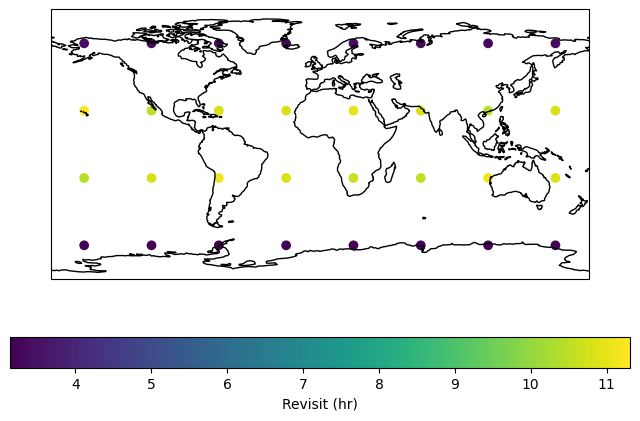

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

reduced_results["revisit_hr"] = reduced_results.revisit / timedelta(hours=1)

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
reduced_results.plot(
    column="revisit_hr",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Revisit (hr)", "orientation": "horizontal"},
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.set_global()
plt.show()

Coverage analyses can also be aggregated to spatial regions for improved visualizations. This example focuses on a smaller spatial region covering the Continental United States (CONUS) defined by a Polygon. Similar to how the `generate_equally_spaced_points` generates uniformly-distributed points (in latitude/longitude), the function `generate_equally_spaced_cells` generates uniformly distributed cells. This example uses twice the characteristic distance (1000 km vs. 500 km) such that each cell covers about four points.

,cell_id,geometry
0,486,"POLYGON Z ((-125 19 0, -125 26.91165 0, -117.0..."
1,487,"POLYGON Z ((-117.04757 19 0, -117.04757 26.911..."
2,488,"POLYGON Z ((-108.05437 19 0, -108.05437 26.911..."
3,489,"POLYGON Z ((-99.06117 19 0, -99.06117 26.91165..."
4,526,"POLYGON Z ((-125 26.91165 0, -125 35.90485 0, ..."
5,527,"POLYGON Z ((-117.04757 26.91165 0, -117.04757 ..."
6,528,"POLYGON Z ((-108.05437 26.91165 0, -108.05437 ..."
7,529,"POLYGON Z ((-99.06117 26.91165 0, -99.06117 35..."
8,566,"POLYGON Z ((-125 35.90485 0, -125 44.89806 0, ..."
9,567,"POLYGON Z ((-117.04757 35.90485 0, -117.04757 ..."


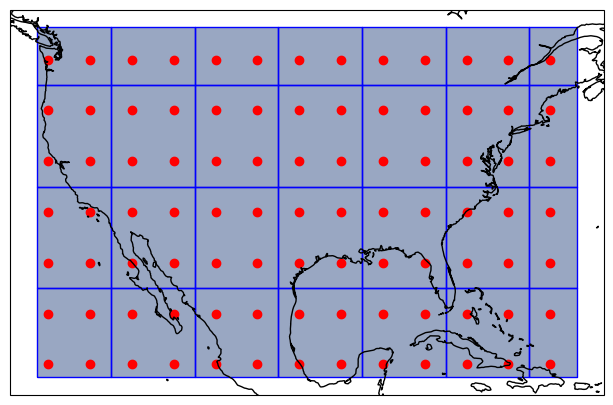

In [26]:
from shapely.geometry import Polygon

target = Polygon([(-125, 50), (-67, 50), (-67, 19), (-125, 19), (-125, 50)])

import geopandas as gpd

target_area = gpd.GeoDataFrame({"geometry": target}, index=[0], crs="EPSG:4326")

from tatc.generation.points import generate_equally_spaced_points
from tatc.generation.cells import generate_equally_spaced_cells

points_df = generate_equally_spaced_points(500e3, mask=target)
cells_df = generate_equally_spaced_cells(1000e3, mask=target)

display(cells_df)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
target_area.plot(alpha=0.5, ax=ax, transform=ccrs.PlateCarree())
points_df.plot(color="r", ax=ax, transform=ccrs.PlateCarree())
cells_df.plot(edgecolor="b", facecolor=(1, 0, 0, 0.1), ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

Similar to the prior case, coverage analysis can be performed for each point.

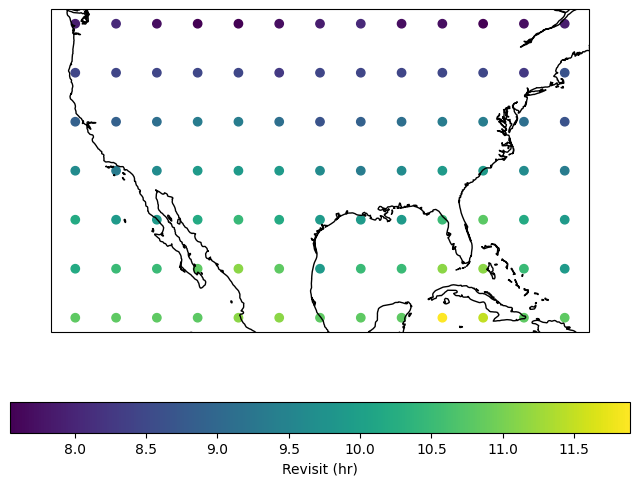

In [27]:
from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

from joblib import Parallel, delayed
from tatc.analysis.coverage import collect_observations

results_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, start, end) for point in points
)
results = pd.concat(results_list, ignore_index=True)

from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)

from tatc.analysis.coverage import reduce_observations

reduced_results = reduce_observations(aggregated_results)

reduced_results["revisit_hr"] = reduced_results.apply(
    lambda r: r["revisit"] / timedelta(hours=1), axis=1
)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
reduced_results.plot(
    column="revisit_hr",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Revisit (hr)", "orientation": "horizontal"},
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
plt.show()

In addition, the results can be merged into the cell specification using a spatial join and dissolve operation. Note that, when working on the reduced results, the revisit aggregation function must perform a weighted average based on the number of samples for each point.

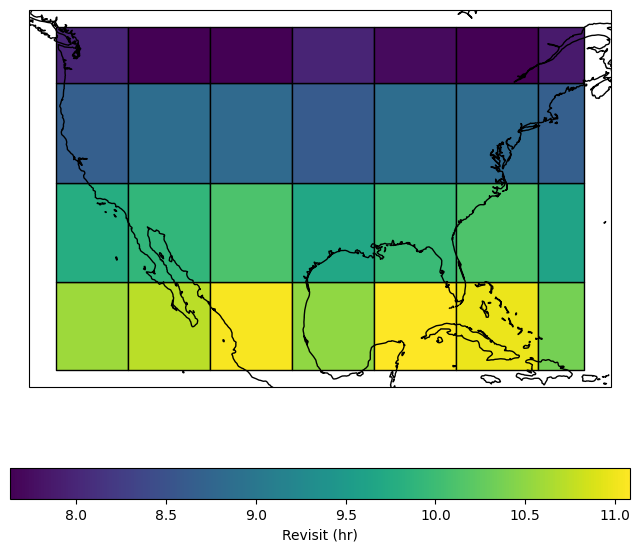

In [28]:
import numpy as np

grid_results = (
    cells_df.sjoin(reduced_results, how="inner", predicate="contains")
    .dissolve(
        by="cell_id",
        aggfunc={
            "samples": "sum",
            "revisit_hr": lambda r: np.average(
                r, weights=reduced_results.loc[r.index, "samples"]
            ),
        },
    )
    .reset_index()
)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={"projection": ccrs.PlateCarree()})
grid_results.plot(
    column="revisit_hr",
    cmap="viridis",
    edgecolor="k",
    legend=True,
    legend_kwds={"label": "Revisit (hr)", "orientation": "horizontal"},
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
plt.show()